# Fetch and preprocess data

Fetch data from the database

In [1]:
from database_facade import db_facade

movies = db_facade.select_movies()
print(f'movies count: {len(movies)}')

movies count: 3025


Preprocess movie reviews helpers

In [64]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer, word_tokenize
from bs4 import BeautifulSoup
import string
import re
import emoji

In [65]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Xotra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Xotra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [100]:
def convert_emoticons(text: str):
    emoticon_mapping = {
        ":)": "smile",
        ":-)": "smile",
        ":(": "sad",
        ":-(": "sad",
        ":D": "laugh",
        ":-D": "laugh"
    }
    
    words = text.split()
    converted_words = [emoticon_mapping.get(word, word) for word in words]
    converted_text = ' '.join(converted_words)
    
    return converted_text

def preprocess_text(text):

    # Remove HTML tags
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()

    # Remove urls
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub('', text)

    # Convert emoticons to text
    # text = convert_emoticons(text)

    # Replace emojis with names
    # text = emoji.demojize(text)

    # For now remove emojis completely - if the model works well might convert them to text as above
    text = emoji.replace_emoji(text, replace='')

    # Tokenization
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    
    # Text normalization
    tokens = [token.lower() for token in tokens]
    
    # Removing punctuation and elipsis
    tokens = [token for token in tokens if token not in string.punctuation and token != '...']
    
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Join tokens back into a single string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

Split the data into training and test sets

In [2]:
train_test_split_ratio = 0.7

split_index = int(len(movies) * train_test_split_ratio)
train_movies = movies[:split_index]
test_movies = movies[split_index:]

print(f'Train movies count: {len(train_movies)}')
print(f'Test movies count: {len(test_movies)}')

Train movies count: 2117
Test movies count: 908


# Dataset and DataLoaders

TMDBDataset class used to load movie data:
- movies should be split to training and test sets before passing them to the class (either pass training or test)
- each poster gets normalised,
- each image has it's height adjusted, so all posters have the same sizes before inputting them to the VAE.
- each movie sample gets all it's reviews preprocessed and a list of preprocessed content is returned

In [ ]:
from torch.utils.data import Dataset, DataLoader
from typing import List
from models.movie import Movie
import os
import cv2

class TMDBDataset(Dataset):
    def __init__(self, movies: List[Movie], directory, desired_image_shape):
        self.movies = movies
        self.directory = directory
        self.desired_image_shape = desired_image_shape

    def __len__(self):
        # Calculate the number of batches per epoch
        return len(self.movies)

    def __getitem__(self, index: int):
        movie = self.movies[index]

        # ---- POSTERS ----
        file_path = movie.poster_path

        # Remove the '/' from the file path - the os lib uses '\' instead
        file_path = file_path[1:]

        # Load and preprocess the image
        image_path = os.path.join(self.directory, file_path)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Change image channels to RGB as cv2 reads BGR by default
        image = image.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
        resized_image = cv2.resize(image, (self.desired_image_shape[1], self.desired_image_shape[0])) # Resize the image to the desired width and height
        resized_image = resized_image.swapaxes(1, 2).swapaxes(0, 1)

        return resized_image, [preprocess_text(review.content) for review in movie.reviews]


# Posters

Draw a histogram of height distribution and find the minium and maximum pixel values

In [8]:
import matplotlib.pyplot as plt
from config import images_directory
import numpy as np

def draw_height_histogram():
    image_heights = []
    min_pixel_value = np.inf
    max_pixel_value = -np.inf

    for filename in os.listdir(images_directory):
        image_path = os.path.join(images_directory, filename)
        image = cv2.imread(image_path)

        height = image.shape[0]

        image_heights.append(height)

        current_min = np.min(image)
        current_max = np.max(image)
        
        if current_min < min_pixel_value:
            min_pixel_value = current_min
        if current_max > max_pixel_value:
            max_pixel_value = current_max

    num_unique_heights = len(set(image_heights))

    plt.hist(image_heights, bins=num_unique_heights)
    plt.xlabel('Image Height')
    plt.ylabel('Frequency (log scale)')
    plt.yscale('log') 
    plt.title('Distribution of Image Heights')
    plt.show()

    print(f'min pixel values:{min_pixel_value}')
    print(f'max pixel values:{max_pixel_value}')

In [2]:
# draw_height_histogram()

Instantiate the variational autoencoder and the train TMDBDataset class used for the DataLoader

In [9]:
from variational_autoencoder_torch import VariationalAutoencoder

desired_image_shape = (256, 224)
batch_size = 16
train_TMDB_dataset = TMDBDataset(train_movies, images_directory, desired_image_shape)
train_TMDB_data_loader = DataLoader(train_TMDB_dataset, batch_size, shuffle=True)

vae = VariationalAutoencoder(input_height=desired_image_shape[0], input_width=desired_image_shape[1], latent_dim=32, device="cuda")

Train the VAE model using the ImageDataLoader class

In [23]:
epochs = 10
epoch_avg_train_losses = vae.train(data_loader=train_TMDB_data_loader, epochs=epochs)

Epoch 10/10: 100%|██████████| 51/51 [00:04<00:00, 11.27batch/s]


Plot the average training loss per epoch

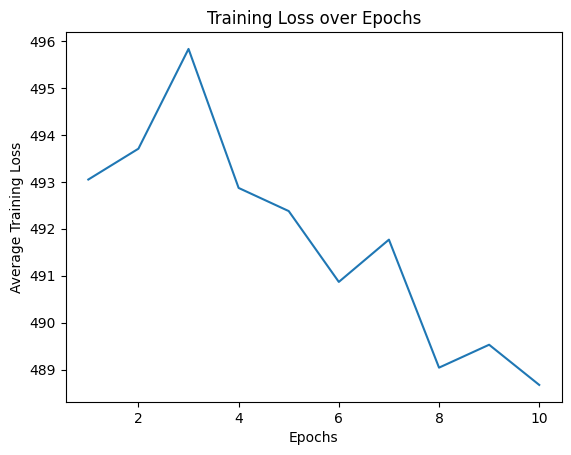

[493.0491129557292, 493.7063640519684, 495.8327756395527, 492.86979346181835, 492.37656417547487, 490.8671007343367, 491.76787193148743, 489.03970995136336, 489.52809891046263, 488.67156204522826]


In [24]:
epochs_range = range(1, epochs + 1)
plt.plot(epochs_range, epoch_avg_train_losses)
plt.xlabel('Epochs')
plt.ylabel('Average Training Loss')
plt.title('Training Loss over Epochs')
plt.show()

Show reconstruction examples

In [11]:
import torch

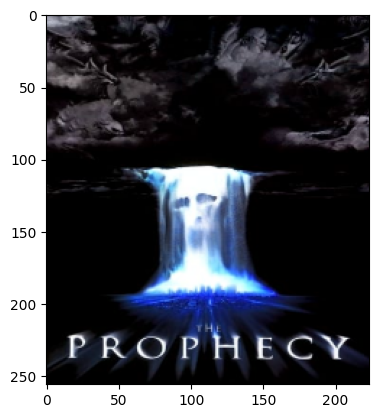

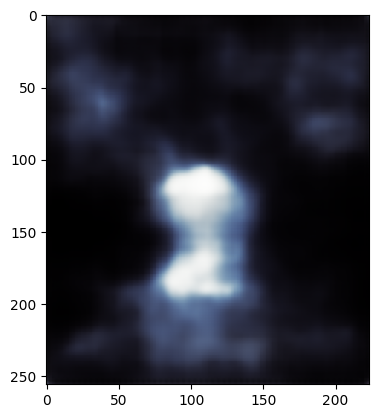

In [29]:
image, _ = train_TMDB_dataset[10]
plt.imshow(image.swapaxes(0, 1).swapaxes(1, 2))

plt.show()

with torch.no_grad():
    reconstructed_image = vae(torch.Tensor(np.expand_dims(image, axis=0)).to("cuda"))
    plt.imshow(reconstructed_image[0][0].cpu().swapaxes(0, 1).swapaxes(1, 2))